# PDF to Audio RAG

## Overview

This notebook demonstrates a Retrieval-Augmented Generation (RAG) system using a PDF document as the knowledge base, with audio input and audio output.\
The PDF content is converted into embeddings using [**Teapot LLM**](https://huggingface.co/teapotai/teapotllm), forming the knowledge base for the RAG pipeline. The user provides an audio query, which is transcribed to text using the [**Whisper large-v3 model**](https://huggingface.co/openai/whisper-large-v3) via an Automatic Speech Recognition (ASR) pipeline. The transcribed text query is then processed using the Teapot LLM RAG system running on **Intel® Core™ Ultra Processors**. The resulting text response is converted back to speech output using the [**SpeechT5 model**](https://huggingface.co/microsoft/speecht5_tts) through a Text-to-Speech (TTS) pipeline.
This audio response can be played directly in the notebook and also saved locally. These models will leverage the [**PyTorch XPU backend**](https://docs.pytorch.org/docs/stable/notes/get_start_xpu.html) for Intel hardware acceleration.

## Workflow

- User provides a *PDF document* to serve as the knowledge base.
- The document is loaded using the [*Langchain PyPDFLoader*](https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/) and split into smaller chunks using the [*Langchain Text Splitter*](https://python.langchain.com/docs/how_to/recursive_text_splitter/).
- These chunks are embedded using the [*Teapot LLM*](https://huggingface.co/teapotai/teapotllm) to form a searchable knowledge base.
- User submits an *audio query*, which is transcribed to text using the [*Whisper large-v3 model*](https://huggingface.co/openai/whisper-large-v3) (ASR).
- Transcribed query is passed to the RAG system, which retrieves relevant information and generates a response.
- The response text is then converted to *audio* using the [*SpeechT5 model*](https://huggingface.co/microsoft/speecht5_tts) (TTS), which can be played and saved.

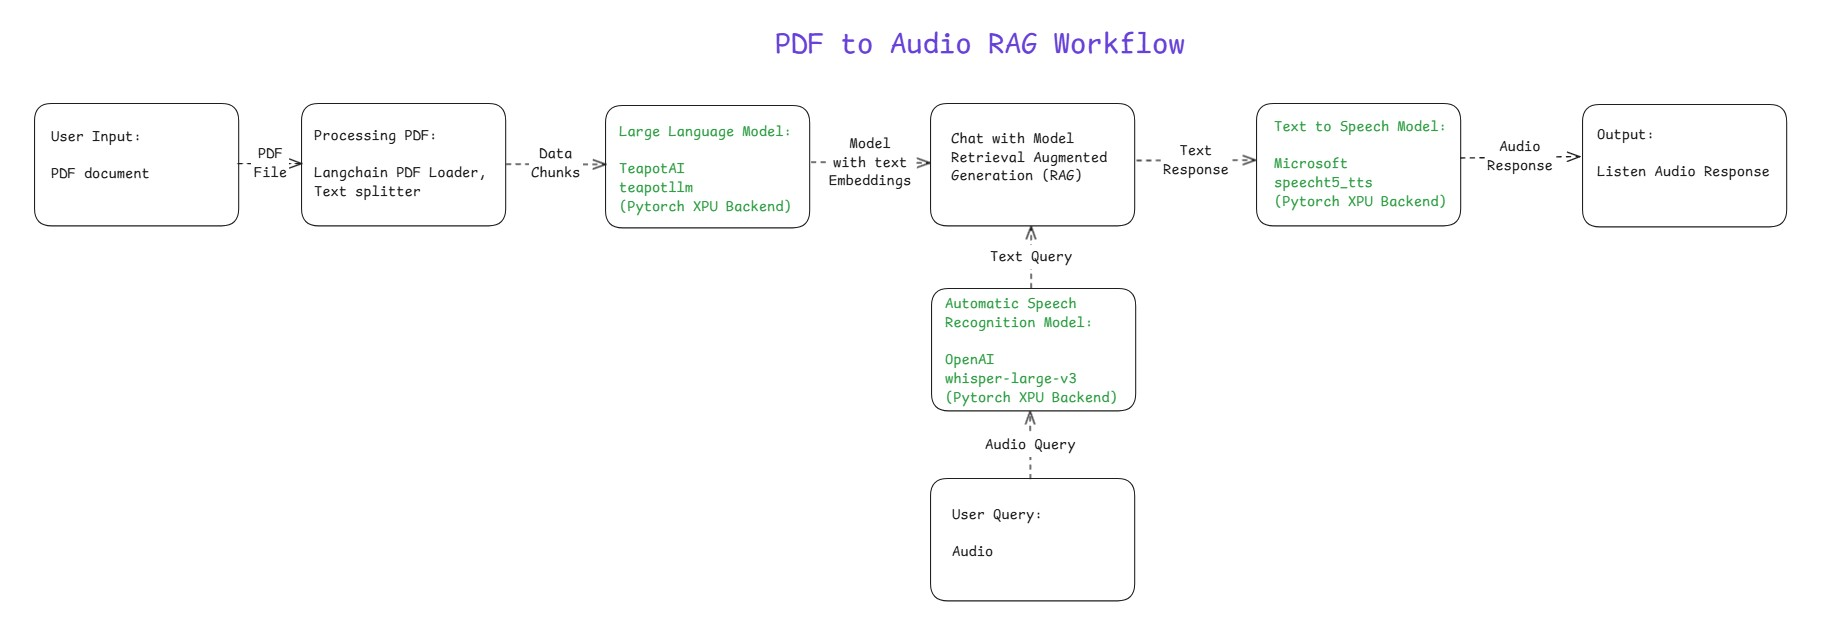

## Import necessary packages
Import all the necessary packages and libraries

In [11]:
import os
import torch
import logging
import torchaudio
import soundfile as sf
from teapotai import TeapotAI
from datasets import load_dataset
from huggingface_hub import notebook_login
from IPython.display import Audio as display_Audio, display
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

logging.basicConfig(level=logging.INFO)

## Login to Huggingface to download the models (Optional)

- Log in to [Huggingface](https://huggingface.co/) using your credentials.
- You’ll need a [User Access Token](https://huggingface.co/docs/hub/security-tokens), which you can generate from your [Settings](https://huggingface.co/settings/tokens) page. This token is used to authenticate your identity with the Hugging Face Hub.
- Once you've generated the token, copy it and keep it secure. Then, run the cell below and paste your access token when prompted.

In [12]:
notebook_login()

## Process PDF

Process the input PDF document. The PDF document is loaded using the [*Langchain PyPDFLoader*](https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/) and split into smaller chunks using the [*Langchain Text Splitter*](https://python.langchain.com/docs/how_to/recursive_text_splitter/).

In [13]:
def process_pdf(pdf_path):
    """
    Load PDF document and split into smaller chunks.

    Args:
        pdf_path (str): PDF file path
    
    Returns:
        list: Data chunks

    Raises:
        Exception: Raises an exception if there is any error during processing the PDF file.
    """
    try:
        if os.path.basename(pdf_path).endswith(".pdf"):
            logging.info(f" Selected {pdf_path} PDF file.")
            loader = PyPDFLoader(pdf_path)
            pages = loader.load()
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=800,
                chunk_overlap=200,
                length_function=len,
            )
            chunks = text_splitter.split_documents(pages)
            documents = []
            for i, chunk in enumerate(chunks):
                page_info = chunk.metadata.get('page', 'Unknown')
                chunk_text = chunk.page_content
                documents.append(f"Chunk {i+1} (Page {page_info}): {chunk_text}")
            logging.info(" Processed PDF file.")            
            return documents
        else:
            logging.info(" Unable to find the PDF file.")
    except Exception as e:
        logging.exception(f" Error while processing the PDF file: {str(e)}")

In [14]:
pdf_path = "dpcpp_cpp_compiler_developer_guide_and_reference.pdf"
documents = process_pdf(pdf_path)

INFO:root: Selected dpcpp_cpp_compiler_developer_guide_and_reference.pdf PDF file.
INFO:root: Processed PDF file.


## Generate Embeddings

These document data chunks are embedded using the [*Teapot LLM*](https://huggingface.co/teapotai/teapotllm) to form a searchable knowledge base.

In [15]:
def generate_embeddings(documents):
    """
    Generate embeddings for the list of data chunks.
    
    Args:
        documents (list): Data chunks
    
    Returns:
        teapot_ai : Model with text embeddings

    Raises:
        Exception: Raises an exception if there is any error while generating embeddings for the data chunks.
    """
    try:
        if documents:
            logging.info(" Found document.")
            teapot_ai = TeapotAI(documents=documents)
            logging.info(" Generated embeddings.")
            return teapot_ai
        else:
            logging.info(" No document found.")
    except Exception as e:
        logging.exception(f" Error while generating embeddings using TeapotAI : {str(e)}")    

In [16]:
teapot_ai = generate_embeddings(documents)

INFO:root: Found document.


 _____                      _         _    ___        __o__    _;;
|_   _|__  __ _ _ __   ___ | |_      / \  |_ _|   __ /-___-\__/ /
  | |/ _ \/ _` | '_ \ / _ \| __|    / _ \  | |   (  |       |__/
  | |  __/ (_| | |_) | (_) | |_    / ___ \ | |    \_|~~~~~~~|
  |_|\___|\__,_| .__/ \___/ \__/  /_/   \_\___|      \_____/
               |_|   
Loading Model
Generating embeddings for documents...


Document Embedding: 100%|████████████████████████████████████████████████████████| 3123/3123 [01:06<00:00, 47.31 doc/s]
INFO:root: Generated embeddings.


## Initialize Audio Models

Initialize [*Whisper large-v3 model*](https://huggingface.co/openai/whisper-large-v3) via Automatic Speech Recognition (ASR) pipeline and [*SpeechT5 model*](https://huggingface.co/microsoft/speecht5_tts) via Text-to-Speech (TTS) model pipelines.

In [17]:
def initialize_audio_models():
    """
    Initialize Automatic Speech Recognition (ASR) and Text-to-Speech (TTS) model pipelines.
    
    Returns:
        pipe :  ASR pipeline for speech-to-text
        synthesiser : TTS Synthesiser for text-to-speech
        speaker_embedding : Speaker embedding for voice

    Raises:
        Exception: Raises an exception if there is any error while loading the audio models.
    """
    try:
        model_id = "openai/whisper-large-v3"
        device = "xpu" if torch.xpu.is_available() else "cpu"
        torch_dtype = torch.float16 if torch.xpu.is_available() else torch.float32
        model = AutoModelForSpeechSeq2Seq.from_pretrained(pretrained_model_name_or_path = model_id, 
                                                          torch_dtype=torch_dtype, 
                                                          low_cpu_mem_usage=True, 
                                                          use_safetensors=True
                                                         )
        model.to(device)
        model = torch.compile(model)
        
        processor = AutoProcessor.from_pretrained(pretrained_model_name_or_path=model_id)
        
        pipe = pipeline("automatic-speech-recognition",
                        model=model,
                        tokenizer=processor.tokenizer,
                        feature_extractor=processor.feature_extractor,
                        torch_dtype=torch_dtype,
                        device=device,
                        return_timestamps=True,
                    )
        synthesiser = pipeline("text-to-speech", 
                               "microsoft/speecht5_tts", 
                               device=device, 
                               torch_dtype=torch_dtype
                              )
        embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
        speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0).to(device, torch_dtype)
        return pipe, synthesiser, speaker_embedding
    except Exception as e:
        logging.exception(f" Error while loading the audio models : {str(e)}")    

In [18]:
pipe, synthesiser, speaker_embedding = initialize_audio_models()

Using the latest cached version of the dataset since Matthijs/cmu-arctic-xvectors couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\gta\.cache\huggingface\datasets\Matthijs___cmu-arctic-xvectors\default\0.0.1\5c1297a9eb6c91714ea77c0d4ac5aca9b6a952e5 (last modified on Mon Jun 23 10:56:47 2025).


## Process Input Query

Load the audio file using torchaudio and generate text for the input audio query

In [19]:
def process_input_query(path_audio):
    """
    Load query audio input and generated text based on the audio.

    Args:
        path_audio: Input audio path.

    Returns:
        question (str): Question based on the input query.

    Raises:
        Exception: Raises an exception if there is any error while loading and generating text for the audio.
    """
    try:
        if path_audio:
            logging.info(" Found audio path.")
            waveform, sample_rate = torchaudio.load(path_audio)
            sample = waveform.numpy()[0]
            with torch.no_grad():
                result = pipe(sample)
            logging.info(f" Query: {result['text']}")
            question = result["text"]
            return question
        else:
            logging.info(" Did not find the audio path.")
    except Exception as e:
        logging.exception(f" Error while processing the input audio query : {str(e)}")

In [20]:
path_audio = "./input_audio_query.wav"
query = process_input_query(path_audio)

INFO:root: Found audio path.
C:\Users\gta\Documents\seshu\02_Speech_n_Text\Final\my-own\AI-PC-Code-Samples\Audio-RAG\PDF-to-Audio-RAG\.venv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:604: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
INFO:root: Query:  how SIMD enabled function pointers work


## Get response and display audio widget

Transcribed query is passed to the RAG system, which retrieves relevant information and generates a response.
The response text is then converted to *audio* using the [*SpeechT5 model*](https://huggingface.co/microsoft/speecht5_tts) (TTS), which can be played inline and saved.

In [21]:
def get_response(question, teapot_ai):
    """
    Get the response from the teapot RAG and display the output audio response inline.

    Args:
        question (str): Input query
        teapot_ai : Model with text embeddings

    Returns:
        answer (str): Generated response from the RAG.

    Raises:
        Exception: Raises an exception if there is any error while getting the response or displaying the output audio response.
    """
    try:
        if query:
            logging.info(f" Query: {query}\n")
            answer = teapot_ai.chat([
                {
                    "role":"system",
                    "content": "You are an agent designed to answer the questions."
                },
                {
                    "role":"user",
                    "content": question
                }
            ])
            logging.info(f" Response: {answer}\n")
            with torch.no_grad():
                speech = synthesiser(answer, forward_params={"speaker_embeddings": speaker_embedding})
            audio_name="output_audio_response.wav"
            sf.write(audio_name, speech["audio"], samplerate=speech["sampling_rate"])
            logging.info(f" Generated audio file name: {audio_name}\n")
            display(display_Audio(audio_name))
            return answer
        else:
            logging.info(" Did not found the question.\n")
    except Exception as e:
        logging.exception(f" Error while generating response : {str(e)}")

In [22]:
answer = get_response(query, teapot_ai)

INFO:root: Query:  how SIMD enabled function pointers work

INFO:root: Response: SIMD-enabled function pointers work by generating short vector variants of the function that you requested, which can perform your function's operation on multiple arguments in a single invocation.

INFO:root: Generated audio file name: output_audio_response.wav

